# Colab

In [1]:
!nvidia-smi -L  

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -r sample_data

In [4]:
!pip install timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


# Parameters

In [5]:
import torch
import timm
import pandas as pd

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cpu')

In [6]:
params = {
    # "model": "vit_large_patch16_224",
    "model": "resnet18",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "im_size": 224,
    "lr": 1e-3,
    "batch_size": 16,
    "num_workers": 2,
    "epochs": 20,
    "folds":3,
    "lr_scheduler": True,
    "early_stopping": True,
    "augmentation": False,
    "targets_exist": False,
    "path": "/content/drive/MyDrive/ISIC/2020"
}
PATH = params['path']

# Handle csv | Meta data

## csv

In [ ]:
import os
os.listdir(PATH)

['ISIC_2020_Training_GroundTruth.csv',
 'ISIC_2020_Training_JPEG.zip',
 'ISIC_2020_Training_Metadata.csv',
 'ISIC_2020_Test_Metadata.csv',
 'ISIC_2020_Test_JPEG.zip',
 'siim-isic-melanoma-classification.zip',
 'Training_GroundTruth.csv',
 'Test_Metadata.csv',
 'train',
 'splits',
 'fold',
 'test',
 'test_meta.csv',
 'train_meta.csv',
 'val_split_meta.csv',
 'train_split_meta.csv',
 'subset_meta.csv',
 'submission.csv',
 'submission_sigmoid.csv',
 'subset.csv',
 'val_split.csv',
 'train_split.csv',
 'test_path.csv',
 'ROC resnet18.png',
 'resnet18_cm.png']

In [ ]:
import pandas as pd
train_csv = f'{PATH}/Training_GroundTruth.csv'
test_csv = f'{PATH}/Test_Metadata.csv'

train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

### add target in case benign_malignant only (2016)

In [ ]:
# header_list = ['image_name','benign_malignant']
# train = pd.read_csv(train_csv, names=header_list, index_col=False)

# header_list = ['image_name','target']
# test = pd.read_csv(test_csv, names=header_list, index_col=False)

# def to_int(label):
#   if label == "benign":
#     return 0.0
#   elif label == "malignant":
#     return 1.0
# train['target'] = train.benign_malignant.apply(to_int)

## Add path to csv

In [ ]:
def to_path(image_name, path):
  return path + image_name + '.jpg'

In [ ]:
train_path = f'{PATH}/train/'
test_path = f'{PATH}/test/'

In [ ]:
train['path'] = train.image_name.apply(to_path, path = train_path)

test['path'] = test.image.apply(to_path, path=test_path)

test.to_csv(f'{PATH}/test_path.csv', index=False)

In [ ]:
train.shape, test.shape

((33126, 9), (10982, 6))

### Train Exploration

#### Target histogram

98.23703435367989
1.762965646320111
0    32542
1      584
Name: target, dtype: int64


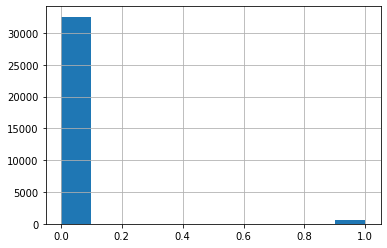

In [ ]:
print(train['target'].value_counts()[0]/len(train['target'])*100)
print(train['target'].value_counts()[1]/len(train['target'])*100)

print(train['target'].value_counts())
train['target'].hist()

#### Genre histogram

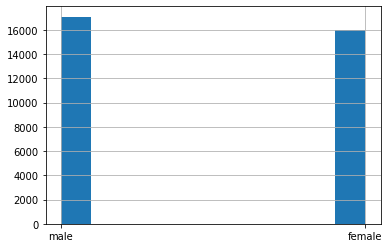

In [ ]:
try:
  train['sex'].hist()
except:
  print("not found in dataframe")
   

#### Age histogram

In [ ]:
try:
  train['age_approx'].value_counts()
except:
  print("not found in dataframe")

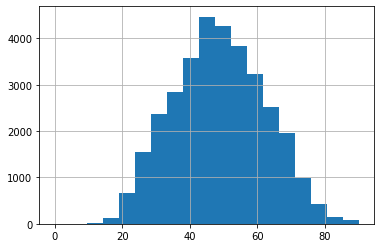

In [ ]:
try:
  train['age_approx'].hist(bins=len(train['age_approx'].unique()))
except:
  print("not found in dataframe")

#### Anatom site

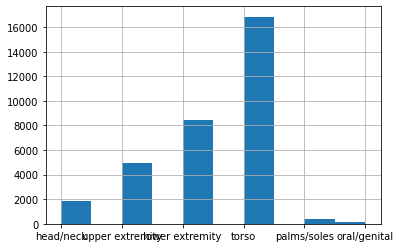

In [ ]:
try:
  train['anatom_site_general_challenge'].hist()
except:
  print("not found in dataframe")

## Meta data

In [ ]:
train_meta = train
test_meta = test

### Meta exploration

In [ ]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   path                           33126 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.3+ MB


In [ ]:
test_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                10982 non-null  object
 1   patient              10982 non-null  object
 2   age_approx           10982 non-null  int64 
 3   anatom_site_general  10982 non-null  object
 4   sex                  10982 non-null  object
 5   path                 10982 non-null  object
dtypes: int64(1), object(5)
memory usage: 514.9+ KB


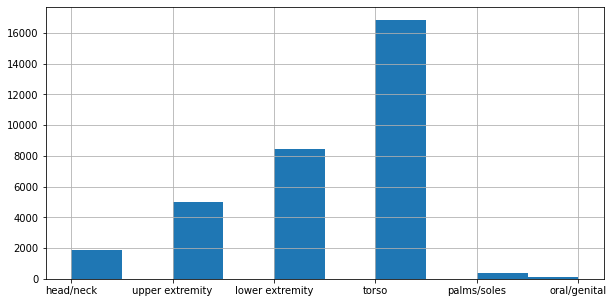

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
train_meta['anatom_site_general_challenge'].hist(ax=ax)

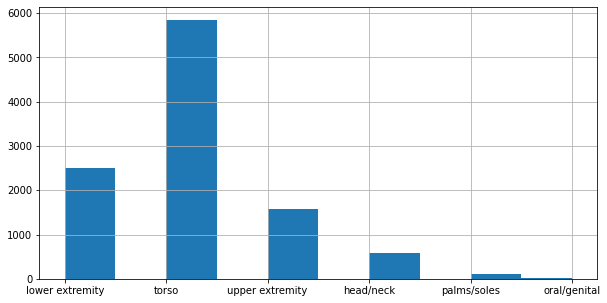

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
test_meta['anatom_site_general'].hist(ax = ax)

### Explore NaN values

In [ ]:
nans_train = train_meta.isna().sum()
nans_test = test_meta.isna().sum()
print(nans_train)
print("\n")
print(nans_test)

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
path                               0
dtype: int64


image                    0
patient                  0
age_approx               0
anatom_site_general    351
sex                      0
path                     0
dtype: int64


Check NaNs by ID

In [ ]:
train_meta['anatom_site_general_challenge'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: anatom_site_general_challenge, Length: 33126, dtype: bool

In [ ]:
null_df = train_meta[train_meta.isnull().any(axis=1)]

In [ ]:
null_df[null_df['patient_id'] == 'IP_8794667']

image_name  patient_id   sex  age_approx  \
780    ISIC_0338752  IP_8794667  male        55.0   
16542  ISIC_5061278  IP_8794667  male        55.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
780                             NaN   unknown           benign       0   
16542                           NaN   unknown           benign       0   

                                                    path  
780    /content/drive/MyDrive/ISIC/2020/train/ISIC_03...  
16542  /content/drive/MyDrive/ISIC/2020/train/ISIC_50...

In [ ]:
for i in range(len(null_df['patient_id'].unique())):
  id = null_df['patient_id'].unique()[i]
  value = null_df['patient_id'].value_counts()[i]
  print(id,'=',value,'\n',null_df.groupby(['patient_id'])['age_approx'].get_group(id).value_counts().to_frame(),'\n')


In [ ]:
train_meta.patient_id[train_meta['sex']==train_meta.isnull()]

In [ ]:
null_df[null_df['sex'].isnull()]

image_name  patient_id  sex  age_approx  \
38     ISIC_0088137  IP_5205991  NaN         NaN   
384    ISIC_0229600  IP_5205991  NaN         NaN   
750    ISIC_0331124  IP_9835712  NaN         NaN   
829    ISIC_0353280  IP_9835712  NaN         NaN   
1687   ISIC_0608625  IP_5205991  NaN         NaN   
...             ...         ...  ...         ...   
30224  ISIC_9132088  IP_5205991  NaN         NaN   
31338  ISIC_9470153  IP_9835712  NaN         NaN   
31451  ISIC_9501056  IP_9835712  NaN         NaN   
32142  ISIC_9710367  IP_5205991  NaN         NaN   
32610  ISIC_9844508  IP_9835712  NaN         NaN   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
38                  lower extremity   unknown           benign       0   
384                 upper extremity   unknown           benign       0   
750                           torso   unknown           benign       0   
829                 upper extremity   unknown           benign       0   
1687                lower extremity   unknown           benign       0   
...                             ...       ...              ...     ...   
30224               upper extremity   unknown           benign       0   
31338               lower extremity   unknown           benign       0   
31451                         torso   unknown           benign       0   
32142               upper extremity   unknown           benign       0   
32610                         torso   unknown           benign       0   

                                                    path  
38     /content/drive/MyDrive/ISIC/2020/train/ISIC_00...  
384    /content/drive/MyDrive/ISIC/2020/train/ISIC_02...  
750    /content/drive/MyDrive/ISIC/2020/train/ISIC_03...  
829    /content/drive/MyDrive/ISIC/2020/train/ISIC_03...  
1687   /content/drive/MyDrive/ISIC/2020/train/ISIC_06...  
...                                                  ...  
30224  /content/drive/MyDrive/ISIC/2020/train/ISIC_91...  
31338  /content/drive/MyDrive/ISIC/2020/train/ISIC_94...  
31451  /content/drive/MyDrive/ISIC/2020/train/ISIC_95...  
32142  /content/drive/MyDrive/ISIC/2020/train/ISIC_97...  
32610  /content/drive/MyDrive/ISIC/2020/train/ISIC_98...  

[65 rows x 9 columns]

In [ ]:
null_df.groupby(['patient_id'])['sex'].value_counts()

patient_id  sex   
IP_0065733  female    2
IP_0099726  male      1
IP_0135517  female    2
IP_0148851  female    2
IP_0307863  male      1
                     ..
IP_9486050  male      1
IP_9563768  female    2
IP_9679829  male      1
IP_9865971  female    2
IP_9899071  female    5
Name: sex, Length: 221, dtype: int64

In [ ]:
train_meta.shape

(33126, 9)

In [ ]:
train_sex = train_meta[(train_meta['sex'] != 'male') & (train_meta['sex'] != 'female')]
train_sex['patient_id'].value_counts()

IP_5205991    48
IP_9835712    17
Name: patient_id, dtype: int64

In [ ]:
train_sex['age_approx'].isna().sum()

65

In [ ]:
train_meta.groupby('patient_id')['sex'].value_counts().to_frame()

sex
patient_id sex        
IP_0001230 female    6
IP_0019713 male     13
IP_0036322 male      5
IP_0038436 male      3
IP_0038545 female   28
...                ...
IP_9989332 female   10
IP_9992027 female   39
IP_9995095 male     14
IP_9996429 male      3
IP_9997715 female   11

[2054 rows x 1 columns]

### Handle NaN values (basic)

#### Creating n_images

In [ ]:
train_meta['n_images'] = train_meta.groupby('patient_id').cumcount().add(1).astype(str).to_frame()
train_meta

image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  \
0                         head/neck   unknown           benign       0   
1                   upper extremity   unknown           benign       0   
2                   lower extremity     nevus           benign       0   
3                         head/neck   unknown           benign       0   
4                   upper extremity   unknown           benign       0   
...                             ...       ...              ...     ...   
33121                         torso   unknown           benign       0   
33122                         torso   unknown           benign       0   
33123               lower extremity   unknown           benign       0   
33124               lower extremity   unknown           benign       0   
33125                         torso     nevus           benign       0   

                                                    path n_images  
0      /content/drive/MyDrive/ISIC/2020/train/ISIC_26...        1  
1      /content/drive/MyDrive/ISIC/2020/train/ISIC_00...        1  
2      /content/drive/MyDrive/ISIC/2020/train/ISIC_00...        1  
3      /content/drive/MyDrive/ISIC/2020/train/ISIC_00...        1  
4      /content/drive/MyDrive/ISIC/2020/train/ISIC_00...        1  
...                                                  ...      ...  
33121  /content/drive/MyDrive/ISIC/2020/train/ISIC_99...       36  
33122  /content/drive/MyDrive/ISIC/2020/train/ISIC_99...       33  
33123  /content/drive/MyDrive/ISIC/2020/train/ISIC_99...       55  
33124  /content/drive/MyDrive/ISIC/2020/train/ISIC_99...       29  
33125  /content/drive/MyDrive/ISIC/2020/train/ISIC_99...        7  

[33126 rows x 10 columns]

##### Train

In [ ]:
train_meta['sex'] = train_meta['sex'].fillna('unknown')
train_meta['sex'].value_counts()

male       17080
female     15981
unknown       65
Name: sex, dtype: int64

#### Age_approx

In [ ]:
train_meta.age_approx= train_meta.age_approx.fillna(0.0).astype(int)
train_meta = train_meta.astype({"age_approx": 'str'})

train_meta['age_approx'] = train_meta['age_approx'].fillna('unknown')
print("Missing values? -> ",train_meta['age_approx'].isna().any())
train_meta['age_approx'].value_counts()

Missing values? ->  False


45    4466
50    4270
55    3824
40    3576
60    3240
35    2850
65    2527
30    2358
70    1968
25    1544
75     981
20     655
80     419
85     149
15     132
90      80
0       70
10      17
Name: age_approx, dtype: int64

In [ ]:
test_meta = test_meta.astype({"age_approx": 'str'})

#### Sex

In [ ]:
train_meta['sex'] = train_meta['sex'].fillna('unknown')
print("Missing values? -> ",train_meta['sex'].isna().any())
train_meta['sex'].value_counts()

Missing values? ->  False


male       17080
female     15981
unknown       65
Name: sex, dtype: int64

#### anatom_site

##### Train

In [ ]:
train_meta['anatom_site_general_challenge'] = train_meta['anatom_site_general_challenge'].fillna('unknown')
print("Missing values? -> ",train_meta['anatom_site_general_challenge'].isna().any())
train_meta['anatom_site_general_challenge'].value_counts()

Missing values? ->  False


torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
unknown              527
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

##### Test

In [ ]:
test_meta['anatom_site_general'] = test_meta['anatom_site_general'].fillna('unknown')
print("Missing values? -> ",test_meta['anatom_site_general'].isna().any())
test_meta['anatom_site_general'].value_counts()

Missing values? ->  False


torso              5847
lower extremity    2501
upper extremity    1573
head/neck           576
unknown             351
palms/soles         108
oral/genital         26
Name: anatom_site_general, dtype: int64

### Encode Metadata

In [ ]:
train_meta.shape, test_meta.shape

((33126, 9), (10982, 6))

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#### train

In [ ]:
hot_enconder = OneHotEncoder()

train_columns = train_meta.columns[2], train_meta.columns[3], train_meta.columns[4]
train_columns =list(train_columns)
hot_enconder.fit(train_meta[train_columns])
hot_enconder.categories_

[array(['female', 'male', 'unknown'], dtype=object),
 array(['0', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55',
        '60', '65', '70', '75', '80', '85', '90'], dtype=object),
 array(['head/neck', 'lower extremity', 'oral/genital', 'palms/soles',
        'torso', 'unknown', 'upper extremity'], dtype=object)]

In [ ]:
hot_enconder.transform([['female', '10','upper extremity']]).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

#### Test

In [ ]:
hot_enconder_test = OneHotEncoder()
test_columns = test_meta.columns[4], test_meta.columns[2], test_meta.columns[3]
test_columns = list(test_columns)
hot_enconder_test.fit(test_meta[test_columns])
hot_enconder_test.categories_

[array(['female', 'male'], dtype=object),
 array(['10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60',
        '65', '70', '75', '80', '85', '90'], dtype=object),
 array(['head/neck', 'lower extremity', 'oral/genital', 'palms/soles',
        'torso', 'unknown', 'upper extremity'], dtype=object)]

#### Create csv

In [ ]:
train_meta.to_csv(f'{PATH}/train_meta.csv',index=False)
test_meta.to_csv(f'{PATH}/test_meta.csv',index=False)

## Hold-out with stratify for training

In [ ]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train, random_state=42, test_size=0.33, shuffle=True, stratify=train['target'])
train_split.shape, val_split.shape

((22194, 9), (10932, 9))

In [ ]:
train_split.to_csv(f'{PATH}/train_split.csv', index=False)
val_split.to_csv(f'{PATH}/val_split.csv', index=False)

## Meta

In [ ]:
from sklearn.model_selection import train_test_split

train_split_meta, val_split_meta = train_test_split(train_meta, random_state=42, test_size=0.33, shuffle=True, stratify=train_meta['target'])
train_split_meta.shape, val_split_meta.shape

((22194, 9), (10932, 9))

In [ ]:
train_split_meta.to_csv(f'{PATH}/train_split_meta.csv', index=False)
val_split_meta.to_csv(f'{PATH}/val_split_meta.csv', index=False)

### Exploration of split distrubition

#### train split

65.8183903882147
1.1803417255328141
0    21803
1      391
Name: target, dtype: int64


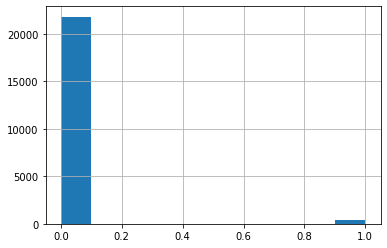

In [ ]:
print(train_split['target'].value_counts()[0]/len(train['target'])*100)
print(train_split['target'].value_counts()[1]/len(train['target'])*100)

print(train_split['target'].value_counts())
train_split['target'].hist()

#### val split

32.41864396546519
0.582623920787297
0    10739
1      193
Name: target, dtype: int64


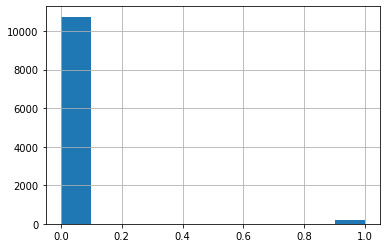

In [ ]:
print(val_split['target'].value_counts()[0]/len(train['target'])*100)
print(val_split['target'].value_counts()[1]/len(train['target'])*100)

print(val_split['target'].value_counts())
val_split['target'].hist()

# Subset

## Create subset

In [ ]:
_, subset = train_test_split(train_split, random_state=42, test_size=0.1, shuffle=True, stratify=train_split['target'])
subset.shape

(2220, 9)

In [ ]:
subset.to_csv(f'{PATH}/subset.csv', index=False)

## Meta

In [ ]:
_, subset_meta = train_test_split(train_split_meta, random_state=42, test_size=0.1, shuffle=True, stratify=train_split_meta['target'])
subset_meta.shape

(2220, 9)

In [ ]:
subset_meta.to_csv(f'{PATH}/subset_meta.csv', index=False)

### Exploration distrubution of subset

98.24324324324324
1.7567567567567568
0    2181
1      39
Name: target, dtype: int64


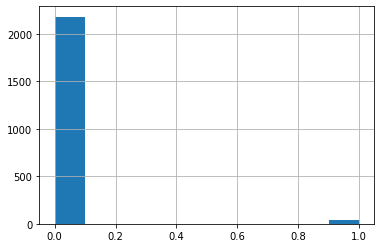

In [ ]:
print(subset['target'].value_counts()[0]/len(subset['target'])*100)
print(subset['target'].value_counts()[1]/len(subset['target'])*100)

print(subset['target'].value_counts())
subset['target'].hist()

# Folds

## Create csv with folds

In [ ]:
import numpy as np
from sklearn import model_selection
KFOLD = params['folds']
kf = model_selection.StratifiedKFold(n_splits=KFOLD, random_state=42, shuffle=True)
for fold_, (train_idx, val_idx) in enumerate(kf.split(X=train,y=train['target'])):
  train.loc[val_idx,'kfold'] = fold_
  train.to_csv(f'{PATH}/train_fold{KFOLD}.csv')
  print("Fold:",fold_+1)
  print(train_idx.shape, val_idx.shape)

# Load csv

## Hold-out split

In [ ]:
train_csv = f'{PATH}/train_split.csv'
val_csv = f'{PATH}/val_split.csv'

train = pd.read_csv(train_csv)
val = pd.read_csv(val_csv)
train.shape, val.shape

((22194, 9), (10932, 9))

## Stratified kFolds 

In [ ]:
KFOLD= params['folds']
train_csv = f'{PATH}/train_fold{KFOLD}.csv'
train = pd.read_csv(train_csv)

## Subset csv load

In [7]:
train_csv = f'{PATH}/subset.csv'
val_csv = f'{PATH}/val_split.csv'

train = pd.read_csv(train_csv)
val = pd.read_csv(val_csv)
train.shape, val.shape

((2220, 9), (10932, 9))

## Meta subset load

In [ ]:
train = pd.read_csv(f'{PATH}/subset_meta.csv')
val = pd.read_csv(f'{PATH}/val_split_meta.csv')

train = train.astype({"age_approx": 'str'})
val = val.astype({"age_approx": 'str'})

train.shape, val.shape

((2220, 9), (10932, 9))

# Dataset.py | Metadata

In [8]:
import os
import cv2
import numpy as np
import albumentations
import torch
from torch.utils.data import Dataset

In [9]:
class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # image = self.transform(image=image)["image"].astype(np.float32)/255.
      # image = self.transform(image=image)["image"].astype(np.float32)
      image = self.transform(image=image)["image"]
      # image = image.transpose(2, 0, 1)/255.
      image = image.transpose(2, 0, 1)
    else:
      image = cv2.resize(image, (params['im_size'],params['im_size']))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/ 255.
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  def __len__(self) -> int:
    return len(self.images)

## Meta dataset

In [ ]:
# from skimage import io
# from skimage.transform import resize

from skimage import io
from skimage.transform import resize

class MelanomaDatasetMeta(Dataset):
  def __init__(self, images, meta, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train
    meta = hot_enconder.transform(meta).toarray()
    self.meta = meta

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    meta = torch.tensor(self.meta[index])
    if self.transform is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      # image = self.transform(image=image)["image"].astype(np.float32)/255.
      # image = self.transform(image=image)["image"].astype(np.float32)
      image = self.transform(image=image)["image"]
      # image = image.transpose(2, 0, 1)/255.
      image = image.transpose(2, 0, 1)
    else:
      image = cv2.resize(image, (params['im_size'],params['im_size']))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/ 255.
      image = image.transpose(2, 0, 1)
    image = torch.tensor(image)
    if self.train:      
      target = torch.tensor([self.labels[index]])
      return image.float(), meta.float(), target.float()
    return image.float(), meta.float()
  
  # def load_img(self, img):
  #   im = io.imread(img)
  #   return resize(im,(256,256))

  # def __getitem__(self, ix):
  #   img = self.load_img(self.images[ix])
  #   img = img.transpose(2, 0, 1)
  #   data = torch.from_numpy(img).float()
  #   target = torch.tensor([self.labels[ix]]).float()
  #   return data, target

  def __len__(self) -> int:
    return len(self.images)

# Calculate mean and std

## Method 1

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean, std = get_mean_and_std(DataLoader(MelanomaDataset(train['path'], train['target'])))
print(mean)
print(std)

(0.7232643, 0.6180579, 0.56661755)
(0.16529222, 0.1724447, 0.19304909)


## Method 2

In [ ]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    return means, stds

In [ ]:
compute_img_mean_std(train['path'])

100%|██████████| 900/900 [00:43<00:00, 20.66it/s]


(224, 224, 3, 900)
mean [0.64762354, 0.64762354, 0.64762354]
std [0.19479683, 0.19479683, 0.19479683]


([0.64762354, 0.64762354, 0.64762354], [0.19479683, 0.19479683, 0.19479683])

## Method 3

In [ ]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs,_ in tqdm(DataLoader(MelanomaDataset(train['path'], train['target']))):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 900/900 [00:51<00:00, 17.59it/s]


In [ ]:
# pixel count
count = len(train['path']) * params['im_size'] * params['im_size']

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))


mean: tensor([0.7233, 0.6181, 0.5666])
std:  tensor([0.1653, 0.1724, 0.1930])


# Augmentation

In [10]:
mean= (0.7232643, 0.6180579, 0.56661755)

std= (0.16529222, 0.1724447, 0.19304909)

In [11]:
import albumentations as A

def transform_aug(im_size):
  transforms_train = A.Compose(
      [
       A.Transpose(p=0.5),
       A.VerticalFlip(p=0.5),
       A.HorizontalFlip(p=0.5),
       A.RandomBrightness(limit=0.2, p=0.75),
       A.RandomContrast(limit=0.2, p=0.75),
       A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.Blur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
       A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
                ], p=0.7),
       A.CLAHE(clip_limit=4.0, p=0.7),
       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
       A.Resize(im_size, im_size),
       A.Cutout(max_h_size=int(im_size * 0.375), max_w_size=int(im_size * 0.375), num_holes=1, p=0.7),
       A.Normalize(mean = (0.7232643, 0.6180579, 0.56661755),std = (0.16529222, 0.1724447, 0.19304909))
       ])
  transforms_val = A.Compose(
      [
       A.SmallestMaxSize(max_size=160),
       A.CenterCrop(height=128, width=128),
       A.Resize(im_size, im_size),
       A.Normalize(mean = (0.7232643, 0.6180579, 0.56661755),std = (0.16529222, 0.1724447, 0.19304909))
       ])
  return transforms_train, transforms_val

# Metrics

In [12]:
from collections import defaultdict
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()
    
  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += 1
    metric["avg"] = metric["val"] / metric["count"]

  def get(self, metric_name):
    return self.metrics.get(metric_name).get('avg')
    
  def __str__(self):
    return " | ".join(
        ["{metric_name}: {avg:.{float_precision}f}".format(metric_name=metric_name,
                                                           avg=metric["avg"],
                                                           float_precision=self.float_precision)
        for (metric_name, metric) in self.metrics.items()])

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

threshold = 0.5

def auc_score(outputs, targets):
  # outputs = torch.sigmoid(outputs)
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  auc = roc_auc_score(targets, outputs)
  return auc

def f1_score_(outputs, targets):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  f1 = f1_score(targets, outputs, average='weighted')
  return f1

def recall_scr(outputs, targets, pos_label = 1):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  recall = recall_score(targets, outputs, pos_label=pos_label)
  return recall

def preicision_score(outputs, targets):
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  preicision = average_precision_score(targets, outputs)
  return preicision

def accuracy_score(outputs, targets):
  # output = torch.sigmoid(outputs) >= 0.5
  outputs = outputs >= threshold
  # outputs = outputs >= 0.0
  targets = targets == 1.0
  return torch.true_divide((targets == outputs).sum(dim=0), outputs.size(0)).item()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def save_roc_curve(outputs, targets, path, label, plot=False,pos_label=1):
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(targets, outputs, pos_label=pos_label)
  plt.plot(false_positive_rate[2],true_positive_rate[2],color="darkorange",label="ROC curve (area = %0.2f)" % roc_auc_score(targets, outputs))
  plt.plot(false_positive_rate, true_positive_rate, lw=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([-0.05, 1.05])
  plt.ylim([0.0, 1.05])
  plt.savefig(f"{path}/folds/{label}.png")
  plt.legend(loc="lower right")
  plt.title('Receiver operating characteristic ROC')
  plt.show() if plot else plt.close()
  plt.clf()

def save_confusion_matrix(outputs, targets, path, label, classes=None, plot=False, percentage=True):
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  cf_matrix = confusion_matrix(targets, outputs)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) if percentage else cf_matrix, index = [i for i in classes], columns = [i for i in classes])
  sn.heatmap(df_cm, annot=True, cmap='Blues')
  plt.title(f'{label} Confusion Matrix')
  plt.savefig(f'{path}/folds/{label}_cm.png')
  plt.show() if plot else plt.close()
  plt.clf()

# Learning rate scheduler | Early stopping

## Learning rate scheduler

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
class LRSchedulerPlateau():
  def __init__(self, optimizer, patience_t=1, mode="min", factor=0.8, min_lr=1e-7):
    self.optimizer = optimizer
    self.patience_t = patience_t
    self.mode = mode
    self.factor = factor
    self.min_lr = min_lr
    self.lr_scheduler = ReduceLROnPlateau( self.optimizer, mode='min', patience=self.patience_t, factor=self.factor, min_lr=self.min_lr, verbose=True)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

## Early stopping

In [15]:
class EarlyStopping():
  def __init__(self, patience=5, min_delta=0.0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
    if self.counter >= self.patience:
      print('INFO: Early stopping')
      self.early_stop = True

# Model

In [16]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes = n_class)
    def forward(self, x):
        x = self.model(x)
        return x
    def get_classifier(self):
        return self.model.get_classifier()
    def fc(self):
        return self.model.fc()

## Meta model

In [ ]:
import timm
import torch.nn as nn
class MelanomaClassifierMeta(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False, num_meta_inputs = 28):
        super().__init__()
        n_features = timm.create_model(model_arch, pretrained=pretrained, num_classes = n_class).get_classifier().in_features
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes = 0)
        
        # meta enconder
        self.meta_model = nn.Sequential(
            nn.Linear(num_meta_inputs, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )

        # Backbone | head
        #(64x512 and 28x128)
        self.head = nn.Linear(n_features+128, n_class, bias=True)
        
    def forward(self, x, meta):
        x = self.model(x)
        # get meta
        meta = self.meta_model(meta)
        # concatenate both
        z = torch.cat([x,meta],1)
        # pass to backbone
        z = self.head(z)
        return z
    def get_classifier(self):
        return self.model.get_classifier()
    def fc(self):
        return self.model.fc()

In [ ]:
# model = MelanomaClassifierMeta('resnet18',n_class=1, pretrained=True)
# output = model(torch.randn(64,3, 224,224), torch.randn(64,28))
# output.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 28]), torch.Size([64, 1]))

# Train.py

## Definition of training and validation functions

In [17]:
from torch.utils.data import DataLoader

def data_loader(df_train, df_valid, transform_tuple= (None,None), batch_size=None):
  dataset = {'train': MelanomaDataset(df_train['path'], df_train['target'],transform=transform_tuple[0]),
             'val': MelanomaDataset(df_valid['path'], df_valid['target'],transform=transform_tuple[1])}
  train_loader_ = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, pin_memory=True)
  val_loader_ = DataLoader(dataset['val'], batch_size=batch_size, pin_memory=True)
  return train_loader_, val_loader_


train_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']
def data_loader_meta(df_train, df_valid, transform_tuple= (None,None), batch_size=None):
  dataset = {'train': MelanomaDataset(df_train['path'], df_train[train_columns], df_train['target'],transform=transform_tuple[0]),
             'val': MelanomaDataset(df_valid['path'], df_valid[train_columns], df_valid['target'],transform=transform_tuple[1])}
  train_loader_ = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, pin_memory=True)
  val_loader_ = DataLoader(dataset['val'], batch_size=batch_size, pin_memory=True)
  return train_loader_, val_loader_

In [18]:
from statistics import mean
def fit(train_loader, model, criterion, optimizer, epoch, params, focal__loss=False):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)

  train_outputs = torch.tensor([]).to(params['device'])
  train_targets = torch.tensor([]).to(params['device'])
  train_loss = []

  val_steps=0

  for _, batch in enumerate(stream, start=1):
    images, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)
    outputs = model(images)
    loss = criterion(outputs, targets)
    if focal__loss:
      loss = focal_loss(criterion(outputs, targets), targets,gamma=0.99, alpha=0.8)

    train_outputs = torch.cat([train_outputs, outputs])
    train_targets = torch.cat([train_targets, targets])
    train_loss.append(loss.item())
    
    accuracy = accuracy_score(outputs, targets)
    f1 = f1_score_(outputs, targets)
    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
        
    try:
      auc = auc_score(outputs, targets)
      metric_monitor.update("AUC", auc)
    except:
      continue

    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if val_steps==5:
      break
    val_steps+=1
  accuracy = accuracy_score(train_outputs, train_targets)
  f1 = f1_score_(train_outputs, train_targets)   
  auc = auc_score(train_outputs, train_targets)
  return mean(train_loss), accuracy, f1, auc

In [19]:
def validate(val_loader, model, criterion, epoch, params, focal__loss=False):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  val_outputs = torch.tensor([]).to(params['device'])
  val_targets = torch.tensor([]).to(params['device'])
  val_loss = []
  val_steps = 0
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      outputs = model(images)
      loss = criterion(outputs, targets)
      if focal__loss:
        loss = focal_loss(criterion(outputs, targets), targets,gamma=0.99, alpha=0.8)
      
      val_outputs = torch.cat([val_outputs, outputs])
      val_targets = torch.cat([val_targets, targets])
      val_loss.append(loss.item())
      
      accuracy = accuracy_score(outputs, targets)
      f1 = f1_score_(outputs, targets)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      try:
        auc = auc_score(outputs, targets)
        metric_monitor.update("AUC", auc)
      except:
        continue
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
      if val_steps==5:
        break
      val_steps+=1
  accuracy = accuracy_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)    
  auc = auc_score(val_outputs, val_targets)
  return mean(val_loss), accuracy, f1, auc

### Meta fit

In [20]:
from statistics import mean
def fit(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)

  train_outputs = torch.tensor([]).to(params['device'])
  train_targets = torch.tensor([]).to(params['device'])
  train_loss = []

  val_steps=0

  for _, batch in enumerate(stream, start=1):
    images, meta, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)

    meta = meta.to(params["device"], non_blocking=True).float()

    outputs = model(images, meta)
    loss = criterion(outputs, targets)

    train_outputs = torch.cat([train_outputs, outputs])
    train_targets = torch.cat([train_targets, targets])
    train_loss.append(loss.item())
    
    accuracy = accuracy_score(outputs, targets)
    f1 = f1_score_(outputs, targets)
    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
        
    try:
      auc = auc_score(outputs, targets)
      metric_monitor.update("AUC", auc)
    except:
      continue

    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if val_steps==5:
      break
    val_steps+=1
  accuracy = accuracy_score(train_outputs, train_targets)
  f1 = f1_score_(train_outputs, train_targets)   
  auc = auc_score(train_outputs, train_targets)
  return mean(train_loss), accuracy, f1, auc

In [21]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  val_outputs = torch.tensor([]).to(params['device'])
  val_targets = torch.tensor([]).to(params['device'])
  val_loss = []
  val_steps = 0
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, meta, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      
      meta = meta.to(params["device"], non_blocking=True).float()

      outputs = model(images, meta)
      loss = criterion(outputs, targets)
      
      val_outputs = torch.cat([val_outputs, outputs])
      val_targets = torch.cat([val_targets, targets])
      val_loss.append(loss.item())
      
      accuracy = accuracy_score(outputs, targets)
      f1 = f1_score_(outputs, targets)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      try:
        auc = auc_score(outputs, targets)
        metric_monitor.update("AUC", auc)
      except:
        continue
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
      if val_steps==5:
        break
      val_steps+=1
  accuracy = accuracy_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)    
  auc = auc_score(val_outputs, val_targets)
  return mean(val_loss), accuracy, f1, auc

## Hold-out fit

In [20]:
from torch.utils.data import DataLoader

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

dataset = {
    'train': MelanomaDataset(train['path'], train['target'],transform=aug_transform[0]),
    'val': MelanomaDataset(val['path'], val['target'],transform=aug_transform[1])
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

# images, labels = next(iter(train_loader))
# images.shape, labels.shape

## Metadata

In [ ]:
from torch.utils.data import DataLoader

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

train_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']

dataset = {
    'train': MelanomaDatasetMeta(train['path'], train[train_columns], train['target'], transform=aug_transform[0]),
    'val': MelanomaDatasetMeta(val['path'], val[train_columns], val['target'], transform=aug_transform[1])
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

# images, meta, labels = next(iter(train_loader))
# images.shape, meta.shape, labels.shape

 # Focal loss

In [142]:
"""
# This python file is implemented eloss functions
@author: Md Mostafa Kamal Sarker
@ email: m.kamal.sarker@gmail.com
@ Date: 23.05.2017
"""

import numpy as np
import torch
import torch.nn.functional as F


def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.
    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """    
    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + 
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss


def CB_loss(logits, labels, samples_per_cls, no_of_classes, loss_type, beta, gamma):
    """Compute the Class Balanced Loss between `logits` and the ground truth `labels`.
    Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
    where Loss is one of the standard losses used for Neural Networks.
    Args:
      labels: A int tensor of size [batch].
      logits: A float tensor of size [batch, no_of_classes].
      samples_per_cls: A python list of size [no_of_classes].
      no_of_classes: total number of classes. int
      loss_type: string. One of "sigmoid", "focal", "softmax".
      beta: float. Hyperparameter for Class balanced loss.
      gamma: float. Hyperparameter for Focal loss.
    Returns:
      cb_loss: A float tensor representing class balanced loss
    """
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    labels_one_hot = F.one_hot(labels, no_of_classes).float()

    weights = torch.tensor(weights).float().to(params["device"], non_blocking=True)
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1,1)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weights = weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim = 1)
        cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights)
    return cb_loss

In [160]:
logits=outputs
labels=targets.squeeze()
no_of_classes= 2
loss_type='focal'
beta=0.4
gamma=0.7
samples_per_cls= [98, 2]

effective_num = 1.0 - np.power(beta, samples_per_cls)


weights = (1.0 - beta) / np.array(effective_num)

weights = weights / np.sum(weights) * no_of_classes
labels_one_hot = F.one_hot(labels, no_of_classes).float()

weights = torch.tensor(weights).float().to(params["device"], non_blocking=True)

weights = weights.unsqueeze(0)

weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot

weights = weights.sum(1)

weights = weights.unsqueeze(1)


weights = weights.repeat(1,no_of_classes)

cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)

ValueError: ignored

In [32]:
from tqdm import tqdm
import time

from timm.optim import AdamP
model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)
# model = MelanomaClassifierMeta(params['model'],n_class=1,pretrained=True)
optimizer = AdamP(model.parameters(), lr=params['lr'])
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

model.to(params['device'])


metric_monitor = MetricMonitor()
model.train()
stream = tqdm(train_loader)

train_outputs = torch.tensor([]).to(params['device'])
train_targets = torch.tensor([]).to(params['device'])
train_loss = []

val_steps=0

  0%|          | 0/35 [00:00<?, ?it/s]

In [33]:
for _, batch in enumerate(stream, start=1):
  if val_steps==10:
    break
  val_steps+=1
  images, targets = batch
  images = images.to(params["device"], non_blocking=True)
  targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)
  outputs = model(images)
  # loss = criterion(outputs, targets)
  loss = focal_loss(criterion(outputs, targets), targets,gamma=0.99, alpha=0.8)

  # loss =  CB_loss(outputs, targets.squeeze(), samples_per_cls= [0.2, 1], no_of_classes= 2, loss_type="focal", beta=0.9999, gamma=0.5)

  train_outputs = torch.cat([train_outputs, outputs])
  train_targets = torch.cat([train_targets, targets])
  train_loss.append(loss.item())
  
  accuracy = accuracy_score(outputs, targets)
  f1 = f1_score_(outputs, targets)
  metric_monitor.update("Loss", loss.item())
  metric_monitor.update("Accuracy", accuracy)
  metric_monitor.update("F1", f1)
      
  try:
    auc = auc_score(outputs, targets)
    metric_monitor.update("AUC", auc)
  except:
    continue

  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=1, metric_monitor=metric_monitor))
accuracy = accuracy_score(train_outputs, train_targets)
f1 = f1_score_(train_outputs, train_targets)   
auc = auc_score(train_outputs, train_targets)

Epoch: 1. Train. Loss: 0.016 | Accuracy: 0.947 | F1: 0.951 | AUC: 0.386:  29%|██▊       | 10/35 [05:12<13:00, 31.22s/it]


# Focal loss 2

In [21]:
def focal_loss(bce_loss, targets, gamma, alpha):
    """Binary focal loss, mean.

    Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
    improvements for alpha.
    :param bce_loss: Binary Cross Entropy loss, a torch tensor.
    :param targets: a torch tensor containing the ground truth, 0s and 1s.
    :param gamma: focal loss power parameter, a float scalar.
    :param alpha: weight of the class indicated by 1, a float scalar.
    """
    p_t = torch.exp(-bce_loss)
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1)  # alpha if target = 1 and 1 - alpha if target = 0
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()

In [74]:
alpha = torch.tensor(0.98)

In [75]:
targets[13:15]

tensor([[1.],
        [0.]], device='cuda:0')

In [76]:
alpha_tensor = (1 - alpha) + targets[13:15] * (2 * alpha - 1) 
alpha_tensor.shape

torch.Size([2, 1])

In [77]:
alpha_tensor

tensor([[0.9800],
        [0.0200]], device='cuda:0')

# Fit

In [27]:
from tqdm import tqdm
import time

from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
fit_lr = []
start = time.time()
best_=0

model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)
# model = MelanomaClassifierMeta(params['model'],n_class=1,pretrained=True)
optimizer = AdamP(model.parameters(), lr=params['lr'])
criterion = nn.BCEWithLogitsLoss()
lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

model.to(params['device'])

for epoch in range(1, params["epochs"] + 1):
  train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = fit(train_loader, model, criterion, optimizer, epoch, params, focal__loss=True)
  val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params, focal__loss=True)
  train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
  val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_f1.append(val_epoch_f1);val_auc.append(val_epoch_auc)
  if val_epoch_auc > best_:
    best_ = val_epoch_auc
    aug = 'aug' if params['augmentation'] else 'no_aug'
    torch.save(model, f'{PATH}/splits/{params["model"]}_{aug}.pth')
    print(f"Saving current best model: {best_:.3f}\n")

  if params['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if params['early_stopping']:
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
      break
  lr_ = get_lr(optimizer)
  fit_lr.append(lr_)
  print('learning rate:',lr_)
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch: 1. Train. Loss: 0.113 | Accuracy: 0.634 | F1: 0.745 | AUC: 0.722:  20%|██        | 28/139 [02:16<09:01,  4.88s/it]
Epoch: 1. Validation. Loss: 0.613 | Accuracy: 0.177 | F1: 0.258 | AUC: 0.622:   2%|▏         | 17/684 [02:34<1:40:48,  9.07s/it]


Saving current best model: 0.578

learning rate: 0.001


Epoch: 2. Train. Loss: 0.010 | Accuracy: 0.958 | F1: 0.965 | AUC: 0.891:  19%|█▊        | 26/139 [02:01<08:47,  4.67s/it]
Epoch: 2. Validation. Loss: 0.048 | Accuracy: 0.854 | F1: 0.903 | AUC: 0.600:   2%|▏         | 17/684 [00:46<30:36,  2.75s/it]


Saving current best model: 0.661

learning rate: 0.001


Epoch: 3. Train. Loss: 0.007 | Accuracy: 0.963 | F1: 0.970 | AUC: 0.489:  21%|██        | 29/139 [02:07<08:04,  4.41s/it]
Epoch: 3. Validation. Loss: 0.004 | Accuracy: 0.965 | F1: 0.965 | AUC: 0.878:   2%|▏         | 17/684 [00:45<29:37,  2.67s/it]


Saving current best model: 0.865

learning rate: 0.001


Epoch: 4. Train. Loss: 0.008 | Accuracy: 0.974 | F1: 0.962 | AUC: 0.615:  12%|█▏        | 16/139 [00:53<06:54,  3.37s/it]
Epoch: 4. Validation. Loss: 0.004 | Accuracy: 0.979 | F1: 0.969 | AUC: 0.700:   2%|▏         | 17/684 [00:45<29:57,  2.69s/it]


learning rate: 0.001


Epoch: 5. Train. Loss: 0.009 | Accuracy: 0.966 | F1: 0.950 | AUC: 0.572:   9%|▊         | 12/139 [00:44<07:47,  3.68s/it]
Epoch: 5. Validation. Loss: 0.004 | Accuracy: 0.979 | F1: 0.969 | AUC: 0.767:   2%|▏         | 17/684 [00:46<30:27,  2.74s/it]


INFO: Early stopping counter 1 of 5
learning rate: 0.001


Epoch: 6. Train. Loss: 0.004 | Accuracy: 0.983 | F1: 0.975 | AUC: 0.633:  15%|█▌        | 21/139 [01:17<07:17,  3.71s/it]
Epoch: 6. Validation. Loss: 0.004 | Accuracy: 0.979 | F1: 0.969 | AUC: 0.556:   2%|▏         | 17/684 [00:45<29:42,  2.67s/it]


Epoch     6: reducing learning rate of group 0 to 8.0000e-04.
INFO: Early stopping counter 2 of 5
learning rate: 0.0008


Epoch: 7. Train. Loss: 0.006 | Accuracy: 0.977 | F1: 0.967 | AUC: 0.623:  15%|█▌        | 21/139 [01:11<06:42,  3.41s/it]
Epoch: 7. Validation. Loss: 0.005 | Accuracy: 0.979 | F1: 0.969 | AUC: 0.511:   2%|▏         | 17/684 [00:44<29:23,  2.64s/it]


INFO: Early stopping counter 3 of 5
learning rate: 0.0008


Epoch: 8. Train. Loss: 0.011 | Accuracy: 0.963 | F1: 0.945 | AUC: 0.696:  10%|█         | 14/139 [00:48<07:11,  3.46s/it]
Epoch: 8. Validation. Loss: 0.005 | Accuracy: 0.979 | F1: 0.969 | AUC: 0.633:   2%|▏         | 17/684 [00:47<30:58,  2.79s/it]


Epoch     8: reducing learning rate of group 0 to 6.4000e-04.
INFO: Early stopping counter 4 of 5
learning rate: 0.00064


Epoch: 9. Train. Loss: 0.005 | Accuracy: 0.981 | F1: 0.972 | AUC: 0.811:  14%|█▎        | 19/139 [00:57<06:06,  3.05s/it]
Epoch: 9. Validation. Loss: 0.005 | Accuracy: 0.979 | F1: 0.969 | AUC: 0.678:   2%|▏         | 17/684 [00:55<36:35,  3.29s/it]

INFO: Early stopping counter 5 of 5
INFO: Early stopping
Training time: 21.236 minutes


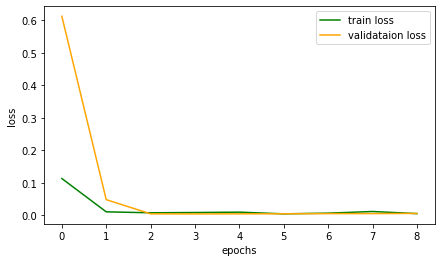

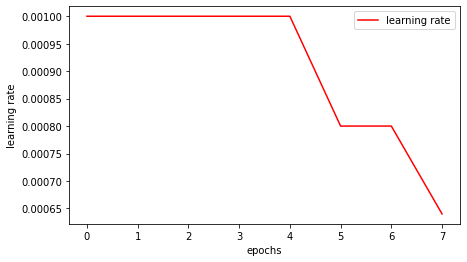

In [34]:
metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
# save_metrics(metrics, names, path=PATH, plot=True, mode='splits')
save_epoch_lr(fit_lr, lr_label= f'learning rate', path=PATH, plot=True, mode='splits')

# Define visuals

In [29]:
import matplotlib.pyplot as plt

def save_epoch_lr(lr_list, lr_label, path, plot = False, mode='folds'):
    plt.figure(figsize=(7, 4))
    plt.plot(lr_list, color='red', label=lr_label)
    plt.xlabel('epochs')
    plt.ylabel(lr_label)
    plt.legend()
    plt.savefig(f"{path}/{mode}/{lr_label}.png")
    plt.show() if plot else plt.close()
    

In [30]:
import matplotlib.pyplot as plt

def save_metrics(metric_list, labels_list, path, fold=None, plot=False, mode='folds'):
  for i in range(len(labels_list)):
    plt.figure(figsize=(7, 4))
    plt.plot(metric_list[i][0], color='green', label=f'train {labels_list[i]}')
    plt.plot(metric_list[i][1], color='orange', label=f'validataion {labels_list[i]}')
    plt.xlabel('epochs')
    plt.ylabel(labels_list[i])
    plt.legend()
    if mode=='folds':
      plt.savefig(f"{path}/{mode}/fold{fold}_{labels_list[i]}.png")
    else:
      plt.savefig(f"{path}/{mode}/{labels_list[i]}.png")
    plt.show() if plot else plt.close()

## Examples

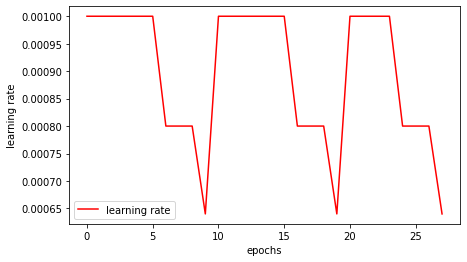

In [ ]:
import matplotlib.pyplot as plt

lr_label= 'learning rate'
plt.figure(figsize=(7, 4))
plt.plot(fit_lr, color='red', label=lr_label)
plt.xlabel('epochs')
plt.ylabel(lr_label)
plt.legend()
plt.savefig(f"./{lr_label}.png")
plt.show()

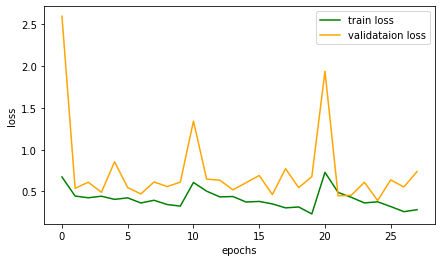

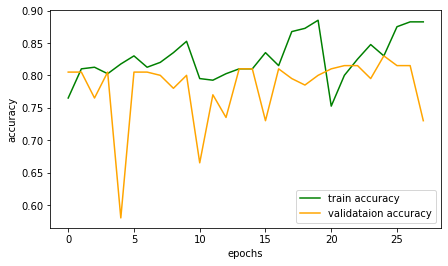

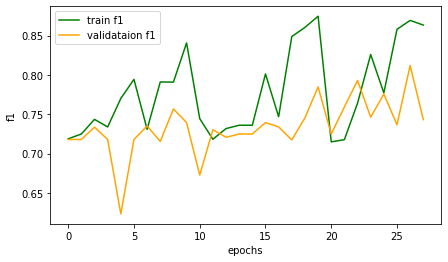

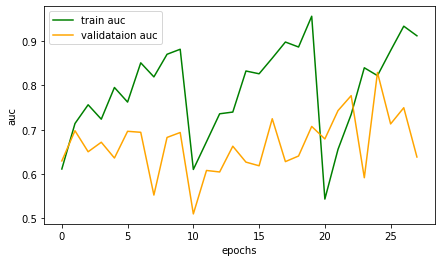

In [ ]:
import matplotlib.pyplot as plt

metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
for i in range(len(names)):
  plt.figure(figsize=(7, 4))
  plt.plot(metrics[i][0], color='green', label=f'train {names[i]}')
  plt.plot(metrics[i][1], color='orange', label=f'validataion {names[i]}')
  plt.xlabel('epochs')
  plt.ylabel(names[i])
  plt.legend()
  plt.savefig(f"./{names[i]}.png")
  plt.show()

## Kfold fit

#### Define function to extract folds from training data

In [ ]:
def get_folds(df, fold):
  '''
  Return training and validation dataframe for specific fold
  df: Whole training + validation dataset
  fold: Specific fold index
  '''
  df_train = df[df.kfold != fold].reset_index(drop=True)
  df_valid = df[df.kfold == fold].reset_index(drop=True)
  return df_train, df_valid

In [ ]:
from tqdm import tqdm
import time


from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
start = time.time()

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

for fold in range(params['folds']):
  best_ = 0
  fit_lr = []
  model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)
  model.to(params['device'])
  optimizer = AdamP(model.parameters(), lr=params['lr'])
  criterion = nn.BCEWithLogitsLoss()
  lr_scheduler = LRSchedulerPlateau(optimizer)
  early_stopping = EarlyStopping()
  train_fold, val_fold = get_folds(train,fold)
  train_loader, val_loader = data_loader(train_fold, val_fold, transform_tuple= aug_transform, batch_size=params['batch_size'])
  for epoch in range(1, params["epochs"] + 1):
    lr_ = get_lr(optimizer)
    fit_lr.append(lr_)
    print('\nLearning rate:',lr_)

    train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = fit(train_loader, model, criterion, optimizer, epoch, params)
    print(f'\nOverall Training. Loss: {train_epoch_loss:.3f}, Accuracy: {train_epoch_acc:.3f}, F1: {train_epoch_f1:.3f}, AUC: {train_epoch_auc:.3f}\n') 
    val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params)
    print(f'\nOverall Validation. Loss: {val_epoch_loss:.3f}, Accuracy: {val_epoch_acc:.3f}, F1: {val_epoch_f1:.3f}, AUC: {val_epoch_auc:.3f}\n')   
    train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
    val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_f1.append(val_epoch_f1);val_auc.append(val_epoch_auc)
    
    if val_epoch_auc > best_:
      best_ = val_epoch_auc
      aug = 'aug' if params['augmentation'] else 'no_aug'
      torch.save(model, f'{PATH}/folds/fold{fold+1}_{params["model"]}_{aug}.pth')
      print(f"Saving current best model for fold {fold+1}: {best_:.3f}\n")

    if params['lr_scheduler']:
      lr_scheduler(val_epoch_loss)
    if params['early_stopping']:
      early_stopping(val_epoch_loss)
      if early_stopping.early_stop:
        break
    if epoch ==5:
      break
  metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
  names = ['loss', 'accuracy', 'f1', 'auc']
  save_metrics(metrics, names, fold=fold+1, path=PATH, plot=False)
  save_epoch_lr(fit_lr, lr_label= f'Fold{fold+1}_learning rate', path=PATH, plot=False)

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

NameError: ignored

# Show batch

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader, denormalize_=False, train_batch=True):
    for batch in data_loader:
      if train_batch:
        images, _ = batch
      else:
        images = batch 
      fig, ax = plt.subplots(figsize=(16, 8))
      ax.set_xticks([]); ax.set_yticks([])
      if denormalize_:
        denorm_images = denormalize(images, mean, std)
        images = denorm_images
      ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
      break

## Meta show_batch

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch_meta(data_loader, denormalize_=False, train_batch=True):
    for batch in data_loader:
      if train_batch:
        images, _, _ = batch
      else:
        images, _ = batch 
      fig, ax = plt.subplots(figsize=(16, 8))
      ax.set_xticks([]); ax.set_yticks([])
      if denormalize_:
        denorm_images = denormalize(images, mean, std)
        images = denorm_images
      ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
      break

In [ ]:
from torch.utils.data import DataLoader

aug_transform = transform_aug(params['im_size']) if params['augmentation'] else (None,None)

train_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']

dataset = {
    'train': MelanomaDataset(train['path'], train[train_columns], train['target'], transform=aug_transform[0]),
    'val': MelanomaDataset(val['path'], val[train_columns], val['target'], transform=aug_transform[1])
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

images, meta, labels = next(iter(train_loader))
images.shape, meta.shape, labels.shape
# show_batch_meta(train_loader)

(torch.Size([64, 3, 224, 224]), torch.Size([64, 28]), torch.Size([64, 1]))

## Hold-out split visuals

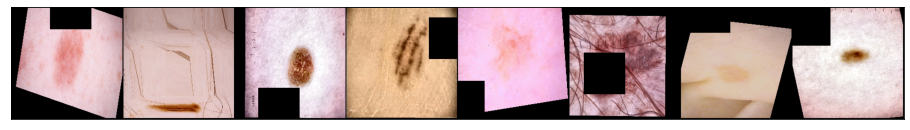

In [ ]:
aug_transform = transform_aug(params['im_size'])

train_loader, val_loader = data_loader(train, val, transform_tuple= aug_transform, batch_size= params['batch_size'])
show_batch(train_loader, denormalize_ = True)
# show_batch(val_loader, denormalize_ = True)

In [ ]:
! ls '/content/drive/MyDrive/ISIC/2020/train/' | wc -l

33126


In [ ]:
! ls '/content/drive/MyDrive/ISIC/2020/test/' | wc -l

10983


In [ ]:
!find '/content/drive/MyDrive/ISIC/2020/train/' -name ISIC_0052212.jpg

/content/drive/MyDrive/ISIC/2020/train/ISIC_0052212.jpg


In [ ]:
!find '/content/drive/MyDrive/ISIC/2020/train/' -name ISIC_2999015.jpg

/content/drive/MyDrive/ISIC/2020/train/ISIC_2999015.jpg


In [ ]:
!find '/content/drive/MyDrive/ISIC/2020/train/' -name *.jpg

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/content/drive/MyDrive/ISIC/2020/train/ISIC_8710040.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_4667975.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_7672567.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_1870377.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_5941271.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_0298093.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_3830701.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_0528791.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_4167610.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_9392704.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_6084191.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_0242801.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_7763042.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_2256519.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_4575717.jpg
/content/drive/MyDrive/ISIC/2020/train/ISIC_9407667.jpg
/content/drive/MyDrive/ISIC/2020/trai

In [ ]:
!unzip '/content/drive/MyDrive/ISIC/2020/ISIC_2020_Test_JPEG.zip' -d '/content/drive/MyDrive/ISIC/2020/test/'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_1997899.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_6690278.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_1392557.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_5467877.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_0665521.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_9802201.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_5664143.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_4341449.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_5774209.jpg  
  inflating: /content/drive/MyDrive/ISIC/2020/test/ISIC_2020_Test_Input/ISIC_2265045.jpg  
  inflating: /content/d

In [ ]:
val['path']

0        /content/drive/MyDrive/ISIC/2020/train/ISIC_31...
1        /content/drive/MyDrive/ISIC/2020/train/ISIC_31...
2        /content/drive/MyDrive/ISIC/2020/train/ISIC_97...
3        /content/drive/MyDrive/ISIC/2020/train/ISIC_83...
4        /content/drive/MyDrive/ISIC/2020/train/ISIC_77...
                               ...                        
10927    /content/drive/MyDrive/ISIC/2020/train/ISIC_95...
10928    /content/drive/MyDrive/ISIC/2020/train/ISIC_44...
10929    /content/drive/MyDrive/ISIC/2020/train/ISIC_79...
10930    /content/drive/MyDrive/ISIC/2020/train/ISIC_55...
10931    /content/drive/MyDrive/ISIC/2020/train/ISIC_96...
Name: path, Length: 10932, dtype: object

In [ ]:
val['target'].value_counts()

0    10739
1      193
Name: target, dtype: int64

## Folds visuals

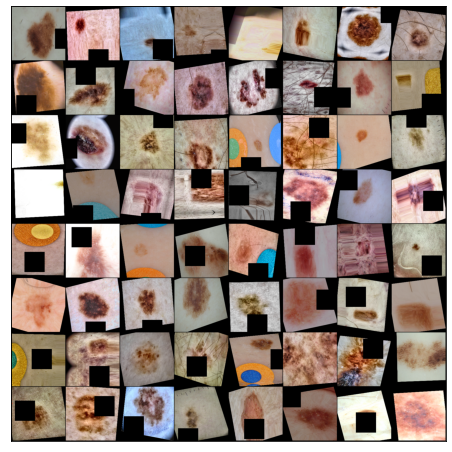

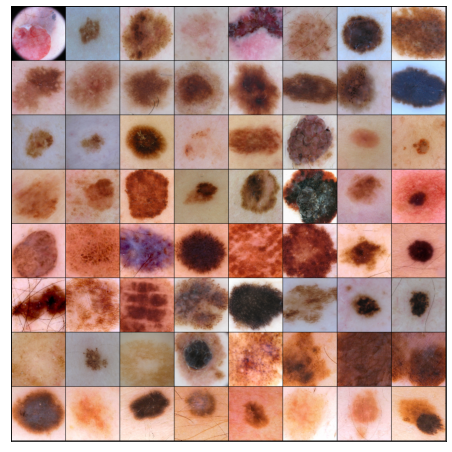

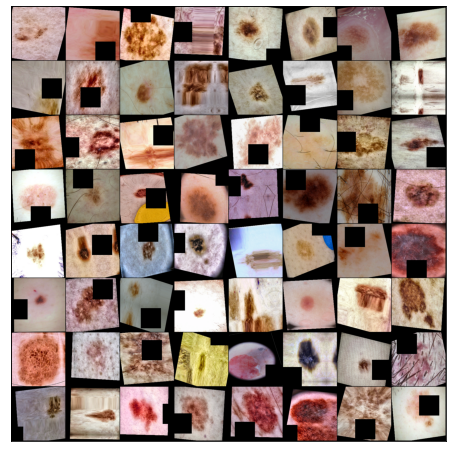

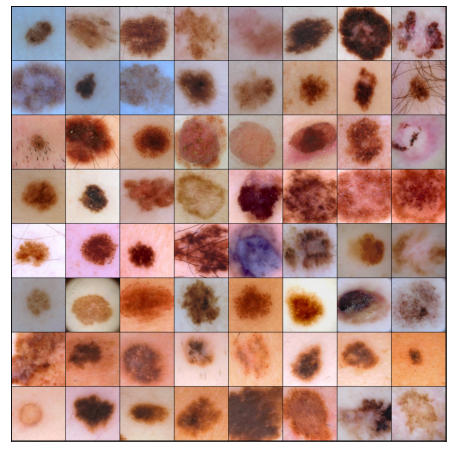

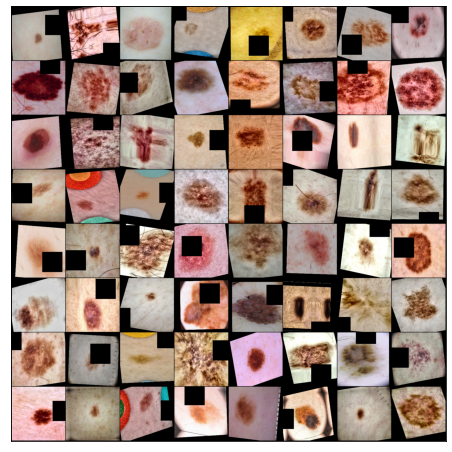

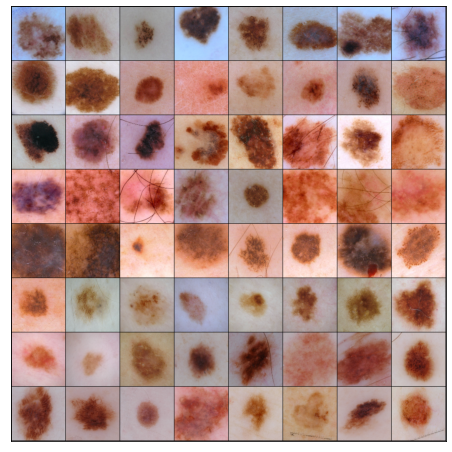

In [ ]:
# aug_transform = transform_aug(params['im_size'])

# for fold in range(KFOLD):
#   train_fold, val_fold = get_folds(train,fold)
#   train_loader, val_loader = data_loader(train_fold, val_fold, transform_tuple= aug_transform, batch_size= params['batch_size'])
#   images, labels = next(iter(train_loader))
#   show_batch(train_loader, denormalize_ = True)
#   show_batch(val_loader, denormalize_ = True)
  

In [ ]:
# show_batch(train_loader, denormalize_ = True)

# Test

## Load Test csv

In [ ]:
test_csv = f'{PATH}/test_path.csv'
test = pd.read_csv(test_csv)
test.shape

(10982, 6)

In [ ]:
from torch.utils.data import DataLoader

test_dataset = MelanomaDataset(test['path'], train=False)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'])
images = next(iter(test_loader))
images.shape

### Meta

In [ ]:
test_csv = f'{PATH}/test_meta.csv'
test = pd.read_csv(test_csv)
test.shape
test = test.astype({"age_approx": 'str'})

test.rename(columns={'anatom_site_general':'anatom_site_general_challenge'}, inplace=True)

In [ ]:
from torch.utils.data import DataLoader
test_columns = ['sex', 'age_approx', 'anatom_site_general_challenge']

test_dataset = MelanomaDatasetMeta(test['path'], test[test_columns], train=False)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], pin_memory=True)
# images, meta = next(iter(test_loader))
# images.shape, meta.shape
# show_batch_meta(test_loader, train_batch=False)

In [ ]:
import pandas as pd
sub = f'{PATH}/submission.csv'

submission = pd.read_csv(sub)

In [ ]:
out = submission.target.to_frame()
out = torch.tensor(out.target.values)
out = torch.sigmoid(out)
out

tensor([0.0025, 0.0022, 0.0071,  ..., 0.3622, 0.0010, 0.1097],
       dtype=torch.float64)

In [ ]:
submission

image_name    target
0      ISIC_0052060 -6.004283
1      ISIC_0052349 -6.138141
2      ISIC_0058510 -4.938386
3      ISIC_0073313 -7.132344
4      ISIC_0073502 -3.518419
...             ...       ...
10977  ISIC_9992485 -4.022043
10978  ISIC_9996992 -3.319140
10979  ISIC_9997917 -0.566034
10980  ISIC_9998234 -6.947645
10981  ISIC_9999302 -2.093784

[10982 rows x 2 columns]

## Hold-out split

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()

PATH = params['path']
aug = 'aug' if params['augmentation'] else 'no_aug'
model_name=params['model']

model = torch.load(f'{PATH}/splits/{model_name}_{aug}.pth',map_location=torch.device(params['device']))
model.to(params['device'])
model.eval()
preds = torch.tensor([]).to(params['device'])
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
stream = tqdm(test_loader)
metric_monitor = MetricMonitor()

test_targets_exist = params['targets_exist']

with torch.no_grad():
  for i, batch in enumerate(stream, start=1):
    if test_targets_exist:
      imgs, targets = batch
      imgs, targets = imgs.to(params['device']), targets.to(params['device'])
      outputs = model(imgs)
      preds = torch.cat([preds, outputs.view(-1)])
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
      val_targets = torch.cat([val_targets, targets.cpu()])
      accuracy = accuracy_score(val_outputs, val_targets)
      auc = auc_score(val_outputs, val_targets)
      f1 = f1_score_(val_outputs, val_targets)
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      metric_monitor.update("AUC", auc)
      stream.set_description("Test. {metric_monitor}".format(metric_monitor=metric_monitor))
    else:
      imgs = batch
      imgs = imgs.to(params['device'])
      outputs = model(imgs)
      preds = torch.cat([preds, outputs.view(-1)])
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
print('INFO: Test completed')
if test_targets_exist:
  accuracy = accuracy_score(val_outputs, val_targets)
  recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
  auc = auc_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)
  print(f'\nOverall Test. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n')
else:
  submission = pd.DataFrame({'image_name': test['image'].values, 'target': preds.cpu().numpy()})
  submission.to_csv(f'{PATH}/submission.csv', index=False)
end = time.time()
print(f"\nTest time: {(end-start)/60:.3f} minutes")

### ROC | Classification report

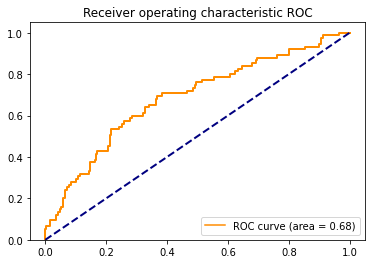

              precision    recall  f1-score   support

      bening       0.95      0.82      0.88       351
   malignant       0.16      0.43      0.23        28

    accuracy                           0.79       379
   macro avg       0.55      0.62      0.56       379
weighted avg       0.89      0.79      0.83       379



<Figure size 432x288 with 0 Axes>

In [ ]:
model_name= params['model']
save_roc_curve(val_outputs, val_targets, path=PATH, label=f'ROC {model_name}', plot=True, pos_label=1)
plot_labels = ['bening', 'malignant']
val_outputs_ = val_outputs >= threshold
report = classification_report(val_outputs_, val_targets, target_names=plot_labels)
print(report)

### Confusion matrix

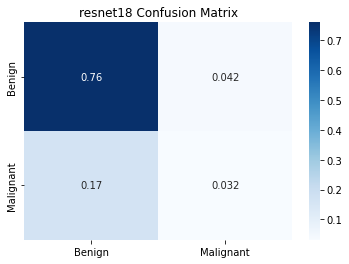

<Figure size 432x288 with 0 Axes>

In [ ]:
classes = ('Benign', 'Malignant')
model_name= params['model']
val_outputs_ = val_outputs >= threshold
save_confusion_matrix(val_outputs_, val_targets, path=PATH, label=model_name, classes=classes, plot=True)

### Meta split with hold-out split

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()

PATH = params['path']
aug = 'aug' if params['augmentation'] else 'no_aug'
model_name=params['model']

model = torch.load(f'{PATH}/splits/{model_name}_{aug}.pth',map_location=torch.device(params['device']))
model.to(params['device'])
model.eval()
preds = torch.tensor([]).to(params['device'])
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
stream = tqdm(test_loader)
metric_monitor = MetricMonitor()

test_targets_exist = params['targets_exist']

with torch.no_grad():
  for i, batch in enumerate(stream, start=1):
    imgs, meta = batch
    imgs, meta = imgs.to(params['device']), meta.to(params['device'])
    outputs = model(imgs, meta)
    preds = torch.cat([preds, outputs.view(-1)])
    val_outputs = torch.cat([val_outputs, outputs.cpu()])
print('INFO: Test completed')
if test_targets_exist:
  accuracy = accuracy_score(val_outputs, val_targets)
  recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
  auc = auc_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)
  print(f'\nOverall Test. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n')
else:
  submission = pd.DataFrame({'image_name': test['image'].values, 'target': preds.cpu().numpy()})
  submission.to_csv(f'{PATH}/submission.csv', index=False)
end = time.time()
print(f"\nTest time: {(end-start)/60:.3f} minutes")

100%|██████████| 172/172 [2:28:00<00:00, 51.63s/it]


INFO: Test completed

Test time: 148.043 minutes


## Folds

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
start = time.time()

acc_predict_folds = []
auc_predict_folds = []
f1_predict_folds = []
val_outputs_folds = []
preds_folds = []
for fold in range(params['folds']):
  model = torch.load(f'{PATH}/folds/fold{fold+1}_resnet18_no_aug.pth',map_location=torch.device(params['device']))
  model.to(params['device'])
  model.eval()
  preds = torch.tensor([]).to(params['device'])
  val_outputs = torch.tensor([])
  val_targets = torch.tensor([])
  stream = tqdm(test_loader)
  metric_monitor = MetricMonitor()
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      imgs, targets = batch
      imgs, targets = imgs.to(params['device']), targets.to(params['device'])
      outputs = model(imgs)
      preds = torch.cat([preds, outputs.view(-1)])
      val_outputs = torch.cat([val_outputs, outputs.cpu()])
      val_targets = torch.cat([val_targets, targets.cpu()])
      accuracy = accuracy_score(val_outputs, val_targets)
      auc = auc_score(val_outputs, val_targets)
      f1 = f1_score_(val_outputs, val_targets)
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      metric_monitor.update("AUC", auc)
      stream.set_description("Test. {metric_monitor}".format(metric_monitor=metric_monitor))
  val_outputs_folds.append(val_outputs)
  preds_folds.append(preds.cpu().numpy())
  accuracy = accuracy_score(val_outputs, val_targets)
  recall_s = recall_scr(val_outputs, val_targets, pos_label=1)
  auc = auc_score(val_outputs, val_targets)
  f1 = f1_score_(val_outputs, val_targets)
  acc_predict_folds.append(accuracy)
  auc_predict_folds.append(auc)
  f1_predict_folds.append(f1)
  print(f'\nOverall Fold {fold+1} test results. Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}, Recall: {recall_s:.3f}\n\n')
print('INFO: Test completed')
preds_fold_mean = np.mean(preds_folds, axis =0)
acc_avg = np.mean(acc_predict_folds, axis=0)
auc_avg = np.mean(auc_predict_folds, axis=0)
f1_avg = np.mean(f1_predict_folds, axis=0)
print(f'\nAverage test results for all folds. Accuracy: {acc_avg:.3f}, F1: {f1_avg:.3f}, AUC: {auc_avg:.3f}\n')
end = time.time()
print(f"\nTest time: {(end-start)/60:.3f} minutes")

Test. Accuracy: 0.780 | F1: 0.684 | AUC: 0.652: 100%|██████████| 12/12 [00:18<00:00,  1.55s/it]



Overall Fold 1 test results. Accuracy: 0.805, F1: 0.720, AUC: 0.641, Recall: 0.013




Test. Accuracy: 0.717 | F1: 0.719 | AUC: 0.637: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it]



Overall Fold 2 test results. Accuracy: 0.763, F1: 0.760, AUC: 0.680, Recall: 0.373




Test. Accuracy: 0.763 | F1: 0.718 | AUC: 0.655: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it]


Overall Fold 3 test results. Accuracy: 0.792, F1: 0.751, AUC: 0.685, Recall: 0.160


INFO: Test completed

Average test results for all folds. Accuracy: 0.786, F1: 0.744, AUC: 0.668



### ROC | Classification report

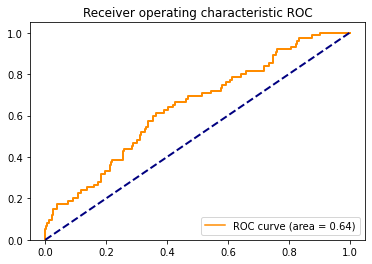

              precision    recall  f1-score   support

      bening       1.00      0.80      0.89       378
   malignant       0.01      1.00      0.03         1

    accuracy                           0.80       379
   macro avg       0.51      0.90      0.46       379
weighted avg       1.00      0.80      0.89       379



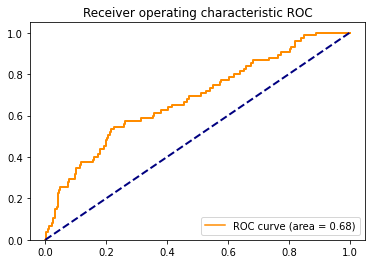

              precision    recall  f1-score   support

      bening       0.86      0.85      0.85       308
   malignant       0.37      0.39      0.38        71

    accuracy                           0.76       379
   macro avg       0.62      0.62      0.62       379
weighted avg       0.77      0.76      0.77       379



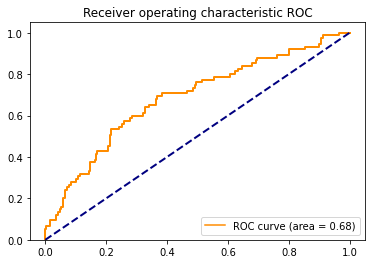

              precision    recall  f1-score   support

      bening       0.95      0.82      0.88       351
   malignant       0.16      0.43      0.23        28

    accuracy                           0.79       379
   macro avg       0.55      0.62      0.56       379
weighted avg       0.89      0.79      0.83       379



<Figure size 432x288 with 0 Axes>

In [ ]:
model_name= params['model']
for fold in range(params['folds']):
  save_roc_curve(val_outputs_folds[fold], val_targets, path=PATH, label=f'ROC {model_name}', plot=True, pos_label=1)
  plot_labels = ['bening', 'malignant']
  val_outputs_ = val_outputs_folds[fold] >= threshold
  report = classification_report(val_outputs_, val_targets, target_names=plot_labels)
  print(report)

### Confusion Matrix

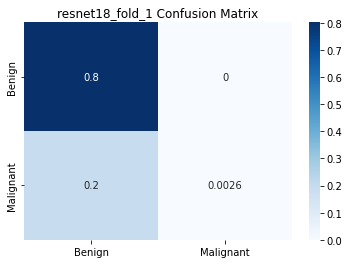

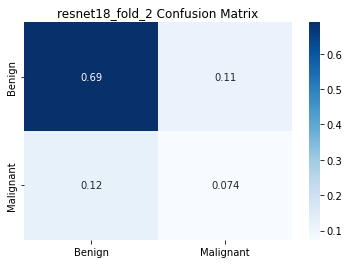

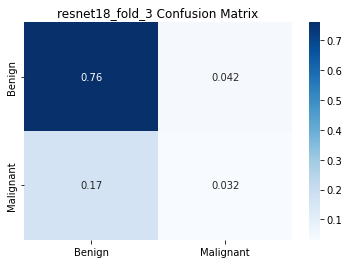

<Figure size 432x288 with 0 Axes>

In [ ]:
classes = ('Benign', 'Malignant')
model_name= params['model']
for fold in range(params['folds']):
  val_outputs_ = val_outputs_folds[fold] >= threshold
  save_confusion_matrix(val_outputs_, val_targets, path=PATH, label=model_name+f'_fold_{fold+1}', classes=classes, plot=True)

# Ensamble

## With submissions

In [23]:
sub_dir = PATH+'/submissions/'
sub_dir

'/content/drive/MyDrive/ISIC/2020/submissions/'

In [33]:
from glob import glob
subs = [pd.read_csv(csv) for csv in sorted(glob(os.path.join(sub_dir, '*csv')))]
sub_probs = [sub.target.rank(pct=True).values for sub in subs]

(10982, 2)

In [40]:
wts = [1/(len(sub_probs))]*(len(sub_probs))
assert len(wts)==len(sub_probs)
sub_ens = np.sum([wts[i]*sub_probs[i] for i in range(len(wts))],axis=0)

df_sub = subs[0]
df_sub['target'] = sub_ens
df_sub.to_csv(f"final_sub1.csv",index=False)


In [38]:
df_sub.shape

(10982, 2)